In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve
from ast import literal_eval

import os
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV, LinearRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, overview, roc_results
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
# data_length = 10000 # TODO: not used
stock = '11869'
plot_dir = 'results_additional_features'

In [3]:
df, df_cv, df_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/avg_mid_bool/', cv=True, include_test=True, length=None)
df.dropna(inplace=True)
df_cv.dropna(inplace=True)
df_test.dropna(inplace=True)

In [4]:
df.rename(columns={'Unnamed: 0': 'datetime'}, inplace=True)
df.index = df['datetime']
df = df.sort_index()
print(df.columns)
df.head(5)

Index(['datetime', 'bid', 'ask', 'bid_price', 'ask_price', 'mid_price',
       'sum_sell_ask', 'sum_buy_bid', 'next_mid_price_avg_2',
       'prev_mid_price_avg_2', 'mid_price_avg_indicator_2',
       'next_mid_price_avg_5', 'prev_mid_price_avg_5',
       'mid_price_avg_indicator_5', 'next_mid_price_avg_10',
       'prev_mid_price_avg_10', 'mid_price_avg_indicator_10',
       'next_mid_price_avg_20', 'prev_mid_price_avg_20',
       'mid_price_avg_indicator_20', 'next_mid_price_avg_50',
       'prev_mid_price_avg_50', 'mid_price_avg_indicator_50',
       'mid_price_indicator', 'queue_imbalance'],
      dtype='object')


,datetime,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,next_mid_price_avg_2,prev_mid_price_avg_2,...,prev_mid_price_avg_10,mid_price_avg_indicator_10,next_mid_price_avg_20,prev_mid_price_avg_20,mid_price_avg_indicator_20,next_mid_price_avg_50,prev_mid_price_avg_50,mid_price_avg_indicator_50,mid_price_indicator,queue_imbalance
datetime,,,,,,,,,,,,,,,,,,,,,
2013-09-17 10:00:00,2013-09-17 10:00:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 1...","[(2682.0, 437.0), (2683.0, 666.0), (2684.0, 37...",2679.0,2682.0,2680.5,437.0,1111.0,2680.25,2679.00,...,2678.40,1,2679.725,2678.375,1,2680.27,2676.73,1,0.0,0.435401
2013-09-17 10:01:00,2013-09-17 10:01:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 1...","[(2682.0, 608.0), (2683.0, 1074.0), (2684.0, 5...",2678.0,2682.0,2680.0,608.0,538.0,2680.00,2679.75,...,2678.65,1,2679.700,2678.500,1,2680.27,2676.88,1,0.0,-0.061082
2013-09-17 10:03:00,2013-09-17 10:03:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 1...","[(2678.0, 780.0), (2679.0, 806.0), (2680.0, 12...",2674.0,2678.0,2676.0,780.0,777.0,2677.75,2680.00,...,2679.05,1,2679.875,2678.700,1,2680.28,2677.12,1,1.0,-0.001927
2013-09-17 10:04:00,2013-09-17 10:04:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 1...","[(2681.0, 257.0), (2682.0, 642.0), (2683.0, 82...",2678.0,2681.0,2679.5,257.0,171.0,2679.50,2678.00,...,2678.85,1,2680.225,2678.600,1,2680.38,2677.10,1,0.0,-0.200935
2013-09-17 10:07:00,2013-09-17 10:07:00,"[(2420.0, 1000.0), (2430.0, 500.0), (2500.0, 1...","[(2680.0, 36.0), (2681.0, 560.0), (2682.0, 823...",2678.0,2680.0,2679.0,36.0,113.0,2679.25,2679.50,...,2679.20,1,2680.525,2678.725,1,2680.47,2677.42,1,1.0,0.516779


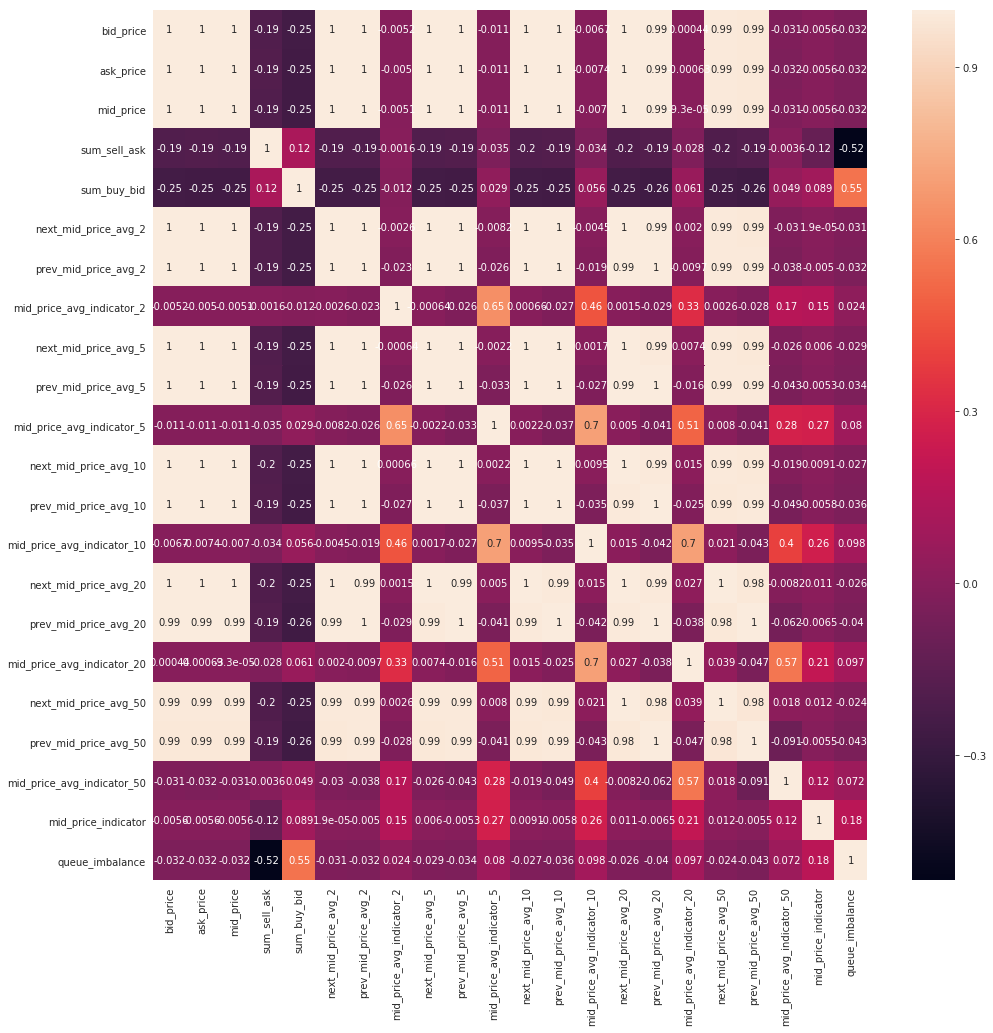

In [5]:
plt.figure(figsize=(16,16))
sns.heatmap(df.corr(), annot=True)

## Let's try to fit SVM

In [6]:
def svc(clf, df, df_cv, columns):
    X = df[columns]
    y = df['mid_price_indicator']
    clf.fit(X, y)
    pred = clf.predict(X)
    pred_cv = clf.predict(df_cv[columns])
    return roc_auc_score(y, pred), roc_auc_score(df_cv['mid_price_indicator'], pred_cv)

In [7]:
def plot_results(clf, df, df_cv, plot_title=''):
    x_columns = {}
    nums = [2, 5, 10, 20, 50]
    x_columns['queue_imb'] = [c for c in df.columns if 'queue_im'  in c]
    x_columns['all_prevs'] = [c for c in df.columns if 'prev_' in c]
    x_columns['all_prevs_and_imb'] = [c for c in df.columns if 'prev_' in c or 'queue_im' in c]
    x_columns['all_prevs_and_imb'] = [c for c in df.columns if 'prev_' in c or 'queue_im' in c]
    for n in nums:
        x_columns['prev_{}'.format(n)] = [
            c for c in df.columns if 'prev_mid_price_avg_{}'.format(n) in c]
        x_columns['prev_{}_and_imb'.format(n)] = [
            c for c in df.columns if 'prev_mid_price_avg_{}'.format(n) in c or 'queue_im' in c]

    results = []
    titles = []
    for title, x_cols in x_columns.items():
        res = svc(clf, df, df_cv, x_cols)
        titles.append(title)
        results.append({'train': res[0], 'cv': res[1]})
    df_res = pd.DataFrame(results, index=titles)
    df_res.to_csv(os.path.join(plot_dir,'{}_{}.csv'.format(stock, plot_title)))
    df_res[['train', 'cv']].plot(kind='bar')
    plt.legend(loc='lower left')
    plt.ylim(0, 1)
    plt.title(plot_title)
    plt.savefig(os.path.join(plot_dir, '{}_{}.png'.format(stock, plot_title)))

In [8]:
%%capture

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
clfs = {
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'GradientBoostingClassifier': GradientBoostingClassifier(learning_rate=0.1),
    'MLPClassifier': MLPClassifier(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'GaussianProcessClassifier': GaussianProcessClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'ExtraTreesClassifier': ExtraTreesClassifier(),
    'RandomForestClassifier': RandomForestClassifier(),
    'AdaBoostClassifier': AdaBoostClassifier(),
    'LogisticRegressionCV': LogisticRegressionCV(),
    'SVC': SVC(kernel='rbf'),
    'GaussianNB': GaussianNB(),
    'QuadraticDiscriminantAnalysis': QuadraticDiscriminantAnalysis(),
    'SVC_100_100': SVC(kernel='rbf', C=100, gamma=100),
    'SVC_100_1': SVC(kernel='rbf', C=100, gamma=1),
    'SVC_1_100': SVC(kernel='rbf', C=1, gamma=100),
    'SVC_01_01': SVC(kernel='rbf', C=0.1, gamma=0.1),
}
for title, clf in clfs.items():
    print(title)
    plot_results(clf, df, df_cv, plot_title=title)

In [9]:
df_res = pd.DataFrame(columns=['train', 'cv', 'classifier'])
for title, clf in clfs.items():
    df_res_temp = pd.read_csv(os.path.join(plot_dir, '{}_{}.csv'.format(stock, title)))
    df_res_temp['classifier'] = title
    df_res = df_res.append(df_res_temp)
    
df_res.sort_values(by='cv', ascending=False)

,Unnamed: 0,classifier,cv,train
0,queue_imb,MLPClassifier,0.571670,0.576868
12,prev_50_and_imb,MLPClassifier,0.571332,0.564668
0,queue_imb,SVC,0.570919,0.575820
0,queue_imb,QuadraticDiscriminantAnalysis,0.569925,0.575842
0,queue_imb,SVC_01_01,0.569925,0.575998
0,queue_imb,GaussianNB,0.569925,0.575842
6,prev_5_and_imb,QuadraticDiscriminantAnalysis,0.569268,0.576550
8,prev_10_and_imb,LogisticRegressionCV,0.568649,0.574972
10,prev_20_and_imb,LogisticRegressionCV,0.568649,0.574972
0,queue_imb,SVC_100_1,0.568649,0.574979


In [10]:
df['mid_price_indicator'].head()

datetime
2013-09-17 10:00:00    0.0
2013-09-17 10:01:00    0.0
2013-09-17 10:03:00    1.0
2013-09-17 10:04:00    0.0
2013-09-17 10:07:00    1.0
Name: mid_price_indicator, dtype: float64